# Keras - Deep Learning on Scenario B

Here, we will be applying deep neural networks in an to attempt to differentiate between Tor traffic types from the ISCXTor2016 dataset. 

In [1]:
# DataFrame handling
import pandas as pd

# Confusion matrix function
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# keras Models
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import CategoricalAccuracy, Recall, Precision

# sklearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split data with stratified cv
from sklearn.model_selection import StratifiedKFold, train_test_split

# Encoding of classifications
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, normalize

print('Imports complete.')

Imports complete.


Using TensorFlow backend.


In [2]:
# Set up a few constants to keep track of
random_state=1
path='../../tor_dataset/Scenario-B/'
dep_var = 'class'
num_classes=0

In [3]:
def get_Xy(filename='', verbose=False):
    """
        This function takes a filename, loads the data into a dataframe, then separates the classification data
        
        args:
            filename => str, path to csv file to be loaded
            
        returns:
            list(X,y) => data, classifications
    """
    df = pd.read_csv(filename)
    
    if verbose:
        print('Before encoding and splitting:')
        print(df.head())
    
    # Actual data
    X = df.loc[:, df.columns != dep_var]
    
    # Set number of classes we see
    num_classes = df[dep_var].nunique()
    
    # Classifications
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[dep_var])
    
    if verbose:
        print('Classification encoding:')
        for i in range(len(encoder.classes_)):
            print('\t{} => {}'.format(i, encoder.classes_[i]))
        
        print('After encoding and splitting:')
        print('X = ')
        print(X.head())
        print('\ny = ')
        print(y[:5])
    
    # X holds the data while y holds the classifications
    return X, y

In [4]:
def show_conf_matrix(model, X_test, y_test, names):
    # Techniques from https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    # and https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix#51163585
    
    predictions = model.predict(X_test)
    matrix = [ [ 0 for j in range(len(predictions[0])) ]  for i in range(len(predictions[0])) ]
    for i in range(len(predictions)):
        pred = predictions[i]
        test = y_test[i]

        guess = np.argmax(pred)
        actual = np.argmax(test)

        matrix[actual][guess] += 1
        
    df_cm = pd.DataFrame(matrix, range(len(matrix)), range(len(matrix)))
    int_cols = df_cm.columns
    df_cm.columns = names
    df_cm.index = names

    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.5) # for label size
    ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=sn.color_palette("Blues")) # font size
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

    plt.show()

Training for TimeBasedFeatures-15s-Layer2.csvMetrics:
	Loss	Acc	Recall	Precision
	0.79	0.70	0.54	0.88

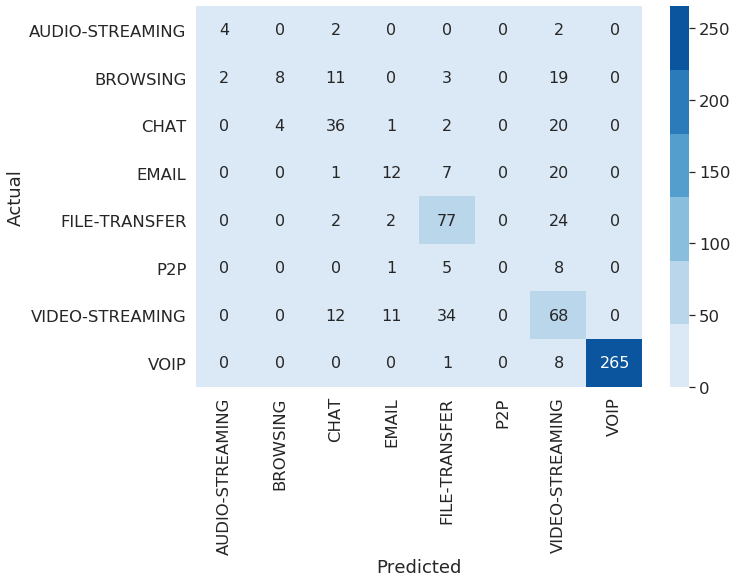

Training for TimeBasedFeatures-30s-Layer2.csvMetrics:
	Loss	Acc	Recall	Precision
	1.07	0.62	0.45	0.78

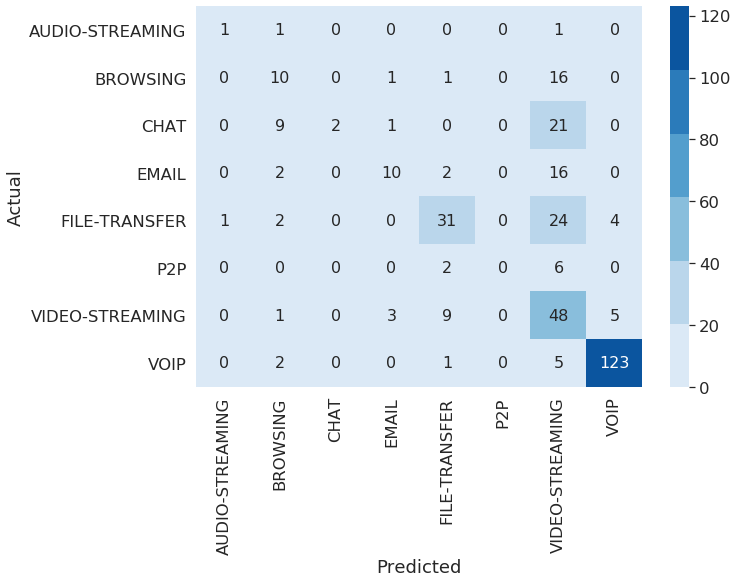

Training for TimeBasedFeatures-60s-Layer2.csvMetrics:
	Loss	Acc	Recall	Precision
	1.19	0.55	0.41	0.78

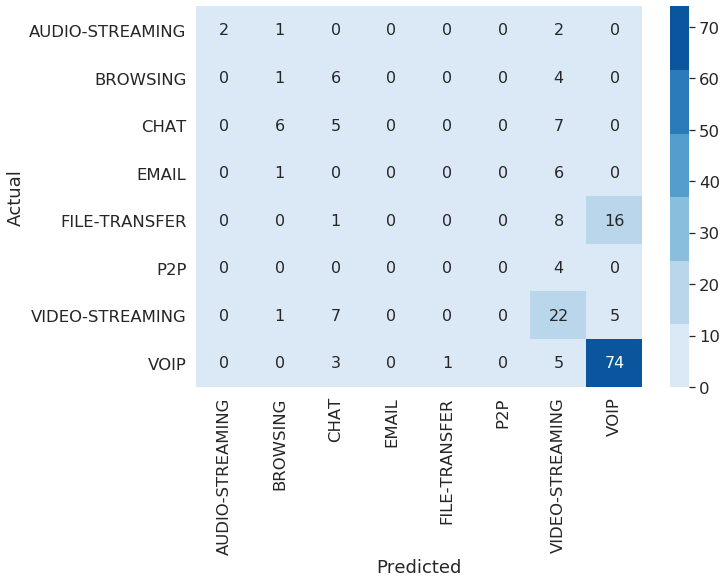

Training for TimeBasedFeatures-120s-Layer2.csvMetrics:
	Loss	Acc	Recall	Precision
	1.17	0.61	0.39	0.95

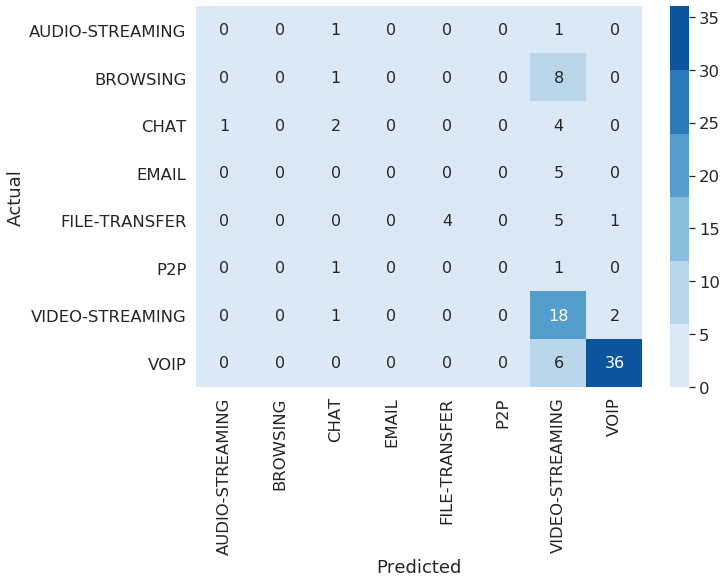

In [5]:
# Just run a DNN experiment
# All of the data files
files=['TimeBasedFeatures-15s-Layer2.csv',
      'TimeBasedFeatures-30s-Layer2.csv',
      'TimeBasedFeatures-60s-Layer2.csv',
      'TimeBasedFeatures-120s-Layer2.csv']

# Gathered from the getXy function
#0 => AUDIO-STREAMING
#1 => BROWSING
#2 => CHAT
#3 => EMAIL
#4 => FILE-TRANSFER
#5 => P2P
#6 => VIDEO-STREAMING
#7 => VOIP
names = ['AUDIO-STREAMING', 'BROWSING', 'CHAT', 'EMAIL', 'FILE-TRANSFER', 'P2P', 'VIDEO-STREAMING', 'VOIP']

for file in files:
    print('Training for {}'.format(file), end='')
    X, y = get_Xy(path + file)
    
    X = normalize(X)
    y = to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Set up the metrics
    metrics = [
        CategoricalAccuracy(),
        Recall(),
        Precision()
    ]
    
    # Deep Neural Network
    dnn = Sequential([
            Dense(256, input_shape=(23,)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(8, activation='softmax')
    ])
    dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
        
    dnn.fit(X_train, y_train, epochs=25, verbose=0)
    
    results = dnn.evaluate(X_test, y_test, verbose=0)
    
    print('Metrics:')
    print('\tLoss\tAcc\tRecall\tPrecision')
    for result in results:
        print('\t{:.2f}'.format(result), end='')
    
    # Show a confusion matrix
    show_conf_matrix(dnn, X_test, y_test, names)

In [8]:
# All of the data files
files=['TimeBasedFeatures-15s-Layer2.csv',
      'TimeBasedFeatures-30s-Layer2.csv',
      'TimeBasedFeatures-60s-Layer2.csv',
      'TimeBasedFeatures-120s-Layer2.csv']

# Lists for accuracies collected from models
list_rf = []
list_dt = []
list_knn = []
list_dnn = []


for file in files:
    print('Training for {}...'.format(file), end='')
    
    # Load in the data
    X, y = get_Xy(path + file)
    X = normalize(X)
    
    # Mean accuracies for each model
    mean_rf = 0 # This is the worst kind of dummy
    mean_dt = 0
    mean_knn = 0
    mean_dnn = 0
    
    # 10-fold Stratified Cross-Validation
    n_splits = 10
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idxs, test_idxs in skf.split(X, y):
        # Define the training and testing sets
        X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
        y_train, y_test = y[train_idxs], y[test_idxs]
        
        # Create a different version of the y_train and y_test for the Deep Neural Network
        y_train_dnn = to_categorical(y_train, num_classes=num_classes)
        y_test_dnn = to_categorical(y_test, num_classes=num_classes)
        
        # Initialize the sklearn models
        rf = RandomForestClassifier(random_state=random_state)
        dt = DecisionTreeClassifier(random_state=random_state)
        knn = KNeighborsClassifier()
        
        # Deep Neural Network
        dnn = Sequential([
            Dense(256, input_shape=(23,)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(8, activation='softmax')
        ])
        dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        
        # Train the models
        rf.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        dnn.fit(x=X_train, y=y_train_dnn, epochs=25, verbose=0, validation_data=(X_test, y_test_dnn))
        
        # Evaluate the models
        results_rf = rf.score(X_test, y_test)
        results_dt = dt.score(X_test, y_test)
        results_knn = knn.score(X_test, y_test)  
        
        # This returns [loss, accuracy]
        results_dnn = dnn.evaluate(X_test, y_test_dnn, verbose=0)
        
        #print('Results from DNN: {}'.format(results_dnn))
        
        # Add the results to the running mean
        mean_rf += results_rf / (n_splits * 1.0)
        mean_dt += results_dt / (n_splits * 1.0)
        mean_knn += results_knn / (n_splits * 1.0)
        mean_dnn += results_dnn[1] / (n_splits * 1.0)
        
    # Push the mean results from all of the splits to the lists
    list_rf.append(mean_rf)
    list_dt.append(mean_dt)
    list_knn.append(mean_knn)
    list_dnn.append(mean_dnn)
    
    print('done')
    
print('All trainings complete!')

Training for TimeBasedFeatures-15s-Layer2.csv...done
Training for TimeBasedFeatures-30s-Layer2.csv...done
Training for TimeBasedFeatures-60s-Layer2.csv...done
Training for TimeBasedFeatures-120s-Layer2.csv...done
All trainings complete!


In [9]:
# Output results
print('File\t\t\t\t\tRF\tDT\tkNN\tDNN')
print('-'*85)
for i in range(len(files)):
    print('{}\t{:.2f}%\t{:.2f}%\t{:.2f}%\t{:.2f}%'.format(files[i], 100*list_rf[i], 100*list_dt[i], 100*list_knn[i], 100*list_dnn[i]))

File					RF	DT	kNN	DNN
-------------------------------------------------------------------------------------
TimeBasedFeatures-15s-Layer2.csv	81.64%	77.80%	71.28%	69.11%
TimeBasedFeatures-30s-Layer2.csv	79.48%	77.20%	67.50%	67.33%
TimeBasedFeatures-60s-Layer2.csv	76.71%	76.08%	63.15%	55.87%
TimeBasedFeatures-120s-Layer2.csv	77.15%	71.42%	63.15%	58.24%
